Convert Inria dataset segmentation mask to coco and xview style object detection annotations
https://project.inria.fr/aerialimagelabeling/contest/


In [ ]:
import os
import json
import numpy as np
import rasterio
from skimage.measure import label, regionprops

folder = "/home/romeokienzler/Downloads/AerialImageDatasetTiledMergedFixedLabels_sample"
images = []
annotations = []
categories = [{"id": 1, "name": "object"}]

ann_id = 0

for img_id, filename in enumerate(sorted(os.listdir(folder))):
    if not filename.endswith("_label.tif"):
        continue

    label_path = os.path.join(folder, filename)
    train_path = label_path.replace("_label.tif", "_train.tif")

    # Read label TIFF
    with rasterio.open(label_path) as src:
        mask = src.read(1)
        height, width = mask.shape

    images.append({
        "id": img_id,
        "file_name": os.path.basename(train_path),
        "width": width,
        "height": height
    })

    # Find connected components (objects)
    labeled = label(mask == 1)
    for region in regionprops(labeled):
        y_min, x_min, y_max, x_max = region.bbox
        bbox = [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]

        annotations.append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": 1,
            "bbox": bbox,
            "area": int(region.area),
            "iscrowd": 0,
        })
        ann_id += 1

# Build COCO dict
coco_output = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}

# Save JSON
with open(os.path.join(folder, "annotations_coco.json"), "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"Created {len(annotations)} annotations for {len(images)} images.")


In [ ]:
import os
import random
import json
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Path to your folder and JSON
json_path = os.path.join(folder, "annotations_coco.json")

# Load COCO annotations
with open(json_path, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]

# Build image_id -> annotations mapping for faster access
ann_by_img = {}
for ann in annotations:
    ann_by_img.setdefault(ann["image_id"], []).append(ann)

# Pick 10 random images (or fewer if less than 10)
n_show = min(10, len(images))
for img_info in random.sample(images, n_show):
    img_path = os.path.join(folder, img_info["file_name"])
    if not os.path.exists(img_path):
        print(f"Missing image: {img_path}")
        continue

    with rasterio.open(img_path) as src:
        img = src.read([1, 2, 3]) if src.count >= 3 else np.repeat(src.read(1)[None, :, :], 3, axis=0)
        img = np.transpose(img, (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img)
    ax.set_title(img_info["file_name"])
    ax.axis("off")

    # Draw bounding boxes
    for ann in ann_by_img.get(img_info["id"], []):
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    plt.show()


In [ ]:
import os
import random
import json
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as patches

json_path = os.path.join(folder, "annotations_coco.json")

# Load COCO annotations
with open(json_path, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]

# Build image_id -> annotations mapping
ann_by_img = {}
for ann in annotations:
    ann_by_img.setdefault(ann["image_id"], []).append(ann)

# 5x5 grid
grid_rows, grid_cols = 5, 5
n_show = min(grid_rows * grid_cols, len(images))
sample_images = random.sample(images, n_show)

fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(20, 20))
axes = axes.flatten()

for ax, img_info in zip(axes, sample_images):
    img_path = os.path.join(folder, img_info["file_name"])
    if not os.path.exists(img_path):
        ax.axis("off")
        continue

    # Load image
    with rasterio.open(img_path) as src:
        img = src.read([1, 2, 3]) if src.count >= 3 else np.repeat(src.read(1)[None, :, :], 3, axis=0)
        img = np.transpose(img, (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    ax.imshow(img)
    ax.set_title(img_info["file_name"], fontsize=8)
    ax.axis("off")

    # Draw bounding boxes
    for ann in ann_by_img.get(img_info["id"], []):
        x, y, w, h = ann["bbox"]
        rect = patches.Rectangle((x, y), w, h, linewidth=1.5, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

# Hide any remaining empty axes
for ax in axes[n_show:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


In [5]:
import os
import json
from glob import glob
import numpy as np
import rasterio
from skimage.measure import label, regionprops

folder = "/home/romeokienzler/Downloads/AerialImageDatasetTiledMergedFixedLabels_sample"
OUT_PATH = os.path.join(folder, "xview_annotations.geojson")
LABEL_SUFFIX = "_label.tif"
IMAGE_SUFFIX = "_train.tif"
CLASS_ID_DEFAULT = 1  # change/mapping for multi-class masks

features = []
feature_id = 0

label_files = sorted(glob(os.path.join(folder, f"*{LABEL_SUFFIX}")))

for lbl_path in label_files:
    base = os.path.basename(lbl_path)
    # derive image filename
    img_filename = base.replace(LABEL_SUFFIX, IMAGE_SUFFIX)

    # read mask
    with rasterio.open(lbl_path) as src:
        mask = src.read(1)  # assume single band mask
        H, W = mask.shape

    # connected components where mask == 1
    labeled = label(mask == 1, connectivity=1)
    regions = regionprops(labeled)

    for r in regions:
        min_row, min_col, max_row, max_col = r.bbox  # (ymin, xmin, ymax, xmax)
        xmin = int(min_col)
        ymin = int(min_row)
        xmax = int(max_col)  # exclusive index; keep as pixel coord like xView does
        ymax = int(max_row)

        # xView stores bounds_imcoords as "xmin,ymin,xmax,ymax"
        bounds_imcoords = f"{xmin},{ymin},{xmax},{ymax}"

        # Geometry: polygon in pixel coordinates (closed ring: repeat first point)
        # Note: xView's geometry is usually lat/lon; here we put image coordinates for convenience.
        polygon = [
            [xmin, ymin],
            [xmax, ymin],
            [xmax, ymax],
            [xmin, ymax],
            [xmin, ymin],
        ]

        props = {
            "image_id": img_filename,        # image file name on which this bbox sits
            "type_id": CLASS_ID_DEFAULT,     # class id; change/mapping if needed
            "bounds_imcoords": bounds_imcoords,
            "area": int(r.area),
            "iscrowd": 0,
        }

        feat = {
            "type": "Feature",
            "id": feature_id,
            "properties": props,
            # geometry uses pixel coordinates here; if you have geotransform, convert to lon/lat
            "geometry": {
                "type": "Polygon",
                "coordinates": [polygon]
            }
        }
        features.append(feat)
        feature_id += 1

# build full GeoJSON
geojson = {
    "type": "FeatureCollection",
    "features": features
}

# write out
with open(OUT_PATH, "w") as f:
    json.dump(geojson, f, indent=2)

print(f"Wrote {len(features)} features to {OUT_PATH}")

Wrote 18859 features to /home/romeokienzler/Downloads/AerialImageDatasetTiledMergedFixedLabels_sample/xview_annotations.geojson


In [12]:
# unfusing bboxes to not cover eg. parks between u shaped building
import os
import json
from glob import glob
import numpy as np
import rasterio
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects, opening, closing, disk
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

# --- Configuration ---
folder = "/home/romeokienzler/Downloads/AerialImageDatasetTiledMergedFixedLabels_sample"
OUT_PATH = os.path.join(folder, "xview_annotations.geojson")
LABEL_SUFFIX = "_label.tif"
IMAGE_SUFFIX = "_train.tif"
CLASS_ID_DEFAULT = 1  # change/mapping for multi-class masks

features = []
feature_id = 0

label_files = sorted(glob(os.path.join(folder, f"*{LABEL_SUFFIX}")))

for lbl_path in label_files:
    base = os.path.basename(lbl_path)
    img_filename = base.replace(LABEL_SUFFIX, IMAGE_SUFFIX)

    # --- Read label mask ---
    with rasterio.open(lbl_path) as src:
        mask = src.read(1)
        H, W = mask.shape

    # --- Improved object separation ---
    binary = mask == 1

    # Morphological smoothing: remove thin bridges and noise
    binary = closing(opening(binary, disk(2)), disk(2))

    # Remove very small components (noise)
    binary = remove_small_objects(binary, min_size=50)

    # Distance transform
    distance = ndi.distance_transform_edt(binary)

    # Detect peaks for splitting
    coords = peak_local_max(distance, footprint=np.ones((15, 15)), labels=binary)
    mask_max = np.zeros(distance.shape, dtype=bool)
    mask_max[tuple(coords.T)] = True

    # Apply watershed to split touching blobs
    markers, _ = ndi.label(mask_max)
    labeled = watershed(-distance, markers, mask=binary)

    # --- Extract bounding boxes ---
    regions = regionprops(labeled)
    for r in regions:
        min_row, min_col, max_row, max_col = r.bbox  # (ymin, xmin, ymax, xmax)
        xmin = int(min_col)
        ymin = int(min_row)
        xmax = int(max_col)
        ymax = int(max_row)

        # xView stores bounds_imcoords as "xmin,ymin,xmax,ymax"
        bounds_imcoords = f"{xmin},{ymin},{xmax},{ymax}"

        # Create pixel coordinate polygon
        polygon = [
            [xmin, ymin],
            [xmax, ymin],
            [xmax, ymax],
            [xmin, ymax],
            [xmin, ymin],
        ]

        props = {
            "image_id": img_filename,
            "type_id": CLASS_ID_DEFAULT,
            "bounds_imcoords": bounds_imcoords,
            "area": int(r.area),
            "iscrowd": 0,
        }

        feat = {
            "type": "Feature",
            "id": feature_id,
            "properties": props,
            "geometry": {"type": "Polygon", "coordinates": [polygon]},
        }

        features.append(feat)
        feature_id += 1

# --- Write GeoJSON ---
geojson = {"type": "FeatureCollection", "features": features}

with open(OUT_PATH, "w") as f:
    json.dump(geojson, f, indent=2)

print(f"Wrote {len(features)} features to {OUT_PATH}")


Wrote 47821 features to /home/romeokienzler/Downloads/AerialImageDatasetTiledMergedFixedLabels_sample/xview_annotations.geojson


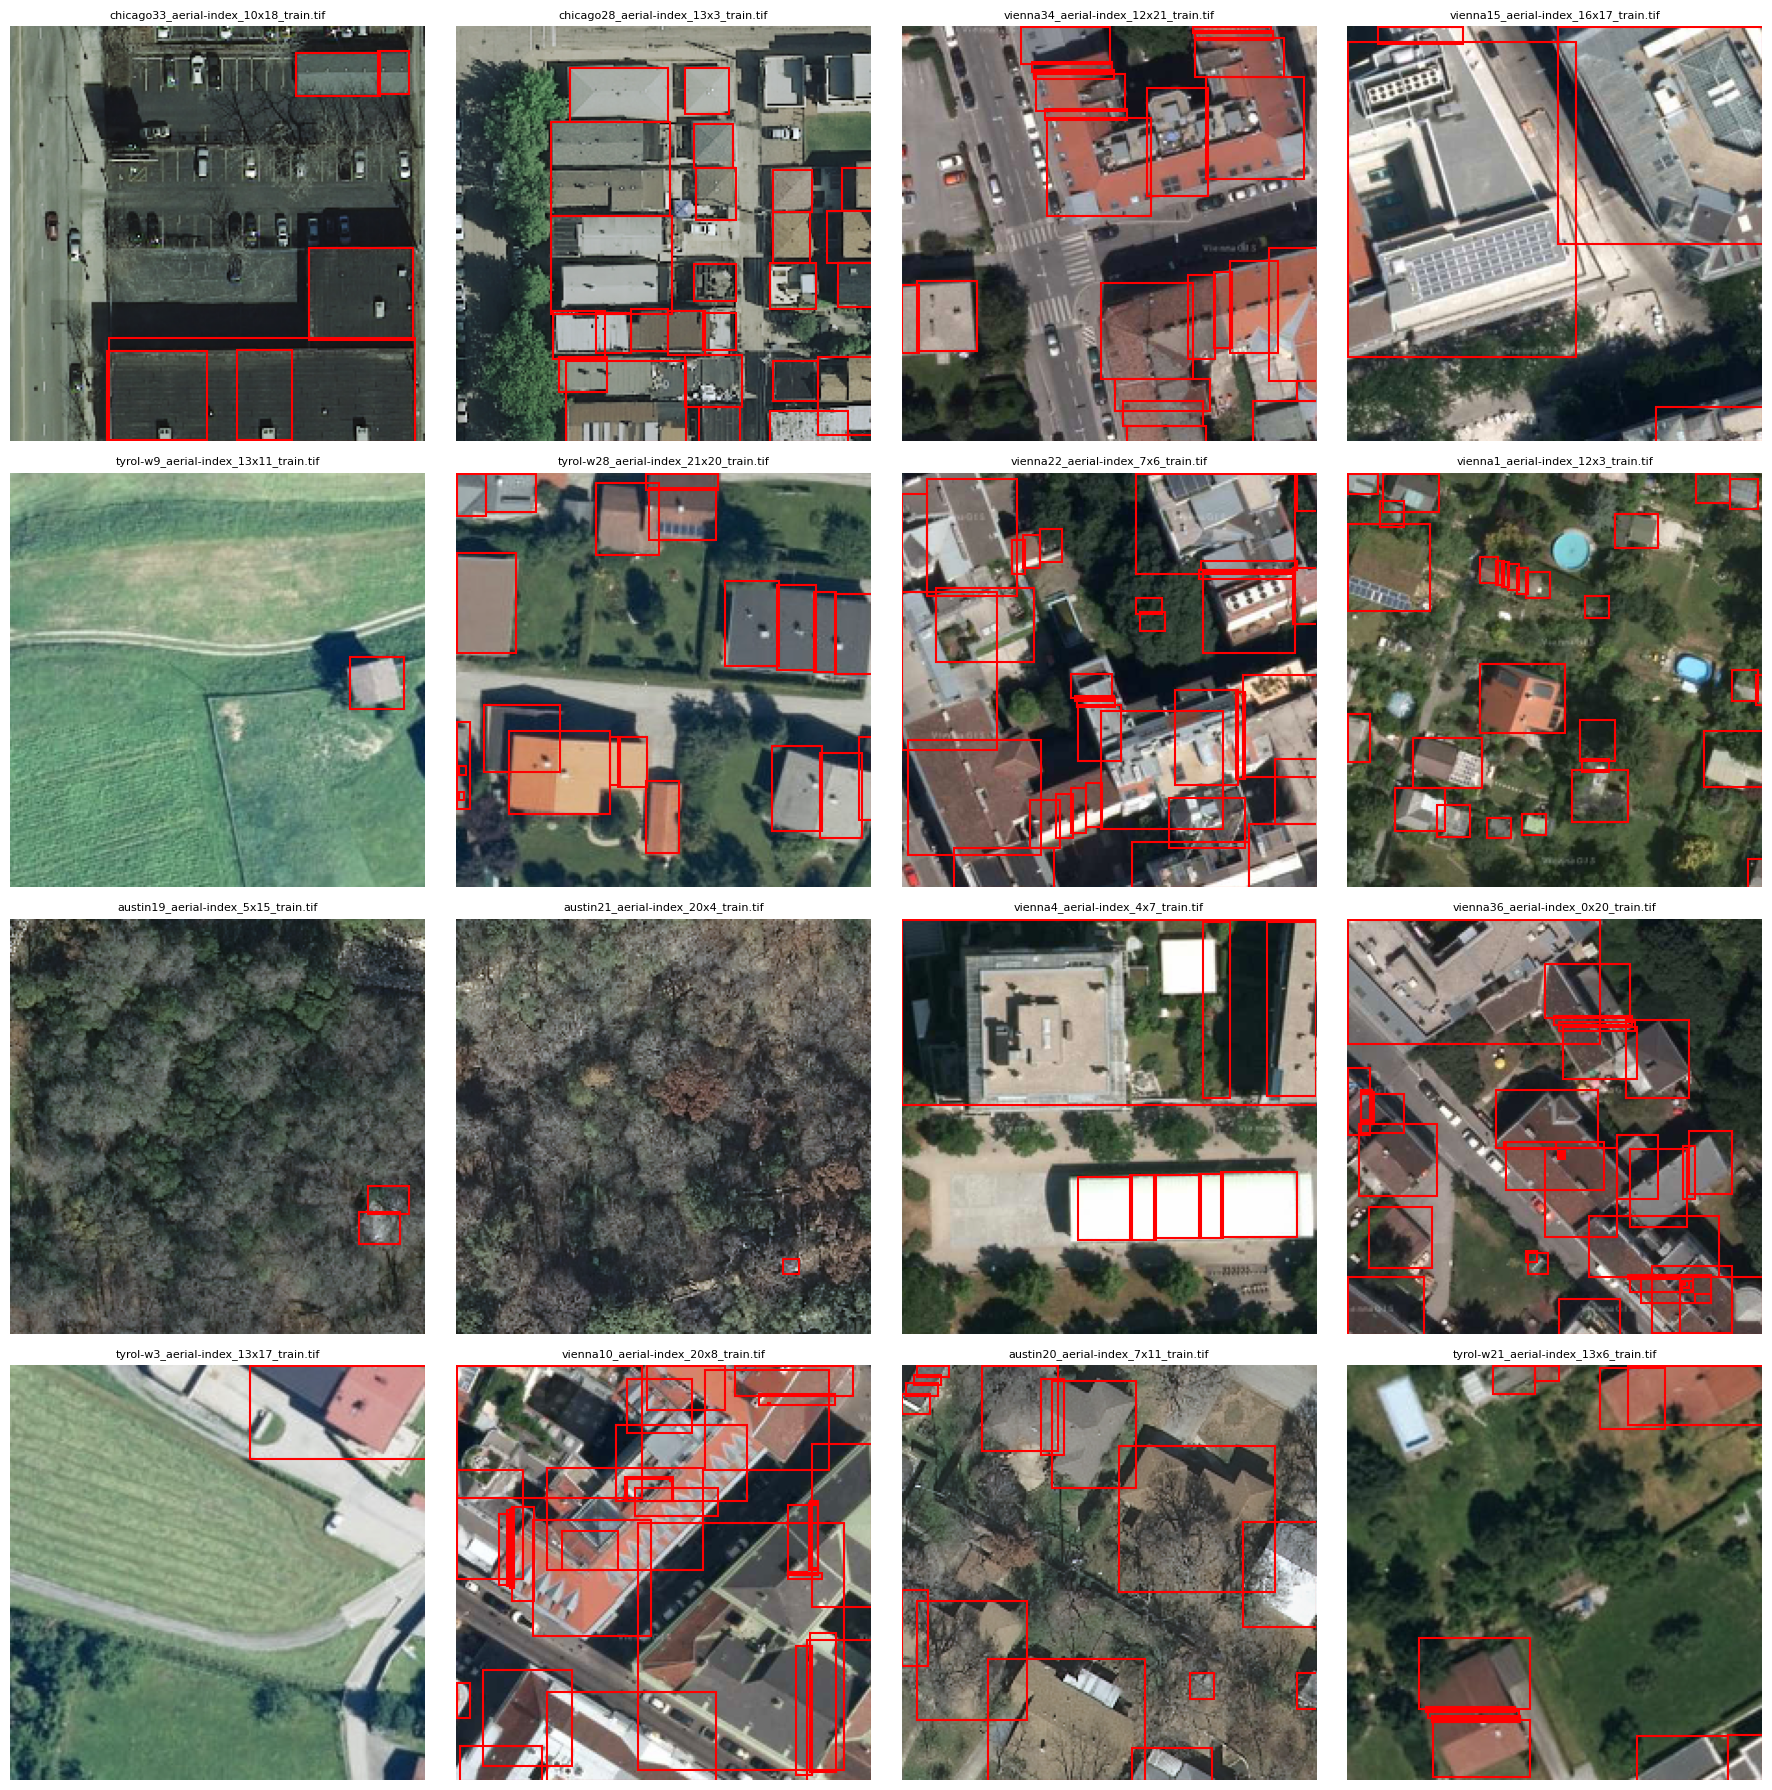

In [11]:
import os
import json
import random
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# ====== CONFIG ======
GEOJSON_PATH = os.path.join(folder, "xview_annotations.geojson")
GRID_ROWS, GRID_COLS = 4, 4
N_SHOW = GRID_ROWS * GRID_COLS
# =====================

# Load xView GeoJSON
with open(GEOJSON_PATH, "r") as f:
    xview_data = json.load(f)

# Group features by image
features_by_image = {}
for feat in xview_data["features"]:
    img_id = feat["properties"]["image_id"]
    features_by_image.setdefault(img_id, []).append(feat)

# Select random subset of images
all_images = list(features_by_image.keys())
sample_images = random.sample(all_images, min(N_SHOW, len(all_images)))

fig, axes = plt.subplots(GRID_ROWS, GRID_COLS, figsize=(18, 18))
axes = axes.flatten()

for ax, img_name in zip(axes, sample_images):
    img_path = os.path.join(folder, img_name)
    if not os.path.exists(img_path):
        print(f"Missing image: {img_path}")
        ax.axis("off")
        continue

    # Read the TIFF
    with rasterio.open(img_path) as src:
        img = src.read()
        if img.shape[0] >= 3:
            img = img[:3]  # take RGB bands
        else:
            img = np.repeat(img[0:1], 3, axis=0)
        img = np.transpose(img, (1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min() + 1e-6)

    ax.imshow(img)
    ax.set_title(img_name, fontsize=8)
    ax.axis("off")

    # Draw bounding boxes from xView features
    for feat in features_by_image[img_name]:
        coords_str = feat["properties"]["bounds_imcoords"]
        try:
            xmin, ymin, xmax, ymax = map(float, coords_str.split(","))
        except Exception:
            continue

        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=1.5,
            edgecolor="red",
            facecolor="none",
        )
        ax.add_patch(rect)

# Hide unused subplots
for ax in axes[len(sample_images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
